# Challenge Description

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than
any other Spanish-speaking country. She therefore went and talked to the international team in
charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanishspeaking
countries had the same translation of the site which was written by a Spaniard. They
agreed to try a test where each country would have its one translation written by a local. That is,
Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican
and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised cause the test is negative. I.e., it
appears that the non-localized translation was doing better!

You are asked to:

* Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better

* Explain why that might be happening. Are the localized translations really worse?

* If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

### 1. Load data 

In [ ]:
import pandas as pd
user = pd.read_csv('../data/Translation_Test/user_table.csv')
test = pd.read_csv('../data/Translation_Test/test_table.csv')
user.shape, test.shape

((452867, 4), (453321, 9))

Test seems to have more data, left join user

In [ ]:
# merge 

df = pd.merge(test, user, how='left', on='user_id')

In [ ]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


In [ ]:
# check missing value and values
pd.concat([df.apply(lambda x: sum(x.isnull())).rename("num_missing"),
          df.apply(lambda x: len(x.unique())).rename("num_unique")], axis=1)

,num_missing,num_unique
user_id,0,453321
date,0,5
source,0,3
device,0,2
browser_language,0,3
ads_channel,271444,6
browser,0,7
conversion,0,2
test,0,2
sex,454,3


Successfully left joined, with 454 missing rows from user table

In [ ]:
df.describe(include='all')

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
count,453321.000000,453321,453321,453321,453321,181877,453321,453321.000000,453321.000000,452867,452867.000000,452867
unique,NaN,5,3,2,3,5,7,NaN,NaN,2,NaN,17
top,NaN,2015-12-04,Ads,Web,ES,Facebook,Android_App,NaN,NaN,M,NaN,Mexico
freq,NaN,141163,181877,251565,377547,68425,155135,NaN,NaN,264485,NaN,128484
mean,499937.514728,NaN,NaN,NaN,NaN,NaN,NaN,0.049579,0.476446,NaN,27.130740,NaN
std,288665.193436,NaN,NaN,NaN,NaN,NaN,NaN,0.217073,0.499445,NaN,6.776678,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,18.000000,NaN
25%,249816.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,22.000000,NaN
50%,500019.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,26.000000,NaN
75%,749522.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,31.000000,NaN


In [ ]:
df.country.fillna('Other', inplace=True)
grouped = df.groupby('country').conversion.mean().reset_index()
grouped = grouped.sort_values('conversion', ascending=False).reset_index(drop=True)
grouped.head()

,country,conversion
0,Spain,0.079719
1,Other,0.068282
2,Costa Rica,0.053494
3,Nicaragua,0.053399
4,Colombia,0.051332


### 2. Naive t-test 

In [ ]:
import numpy as np
np.mean(df[df.test == 1].conversion.values), np.mean(df[df.test == 0].conversion.values)

# control group, test group

(0.043424713982118966, 0.055178690306651276)

In [ ]:
from statsmodels.stats.weightstats import ttest_ind

ttest_ind(df[df.test == 1].conversion.values,
          df[df.test == 0].conversion.values,
          usevar='unequal',
          alternative='smaller')

# t stat, p value, df

(-18.312271285739907, 3.515388372179287e-75, 453150.8198365266)

Too good to be true...

### 3. Exploration

In [ ]:
df.date = pd.to_datetime(df.date)

In [ ]:
# test control ratio

ratio = (df[df.test == 1].groupby('date').conversion.mean()/df[df.test ==0].groupby('date').conversion.mean()).reset_index()
ratio

,date,conversion
0,2015-11-30,0.764911
1,2015-12-01,0.771928
2,2015-12-02,0.798965
3,2015-12-03,0.782333
4,2015-12-04,0.803564


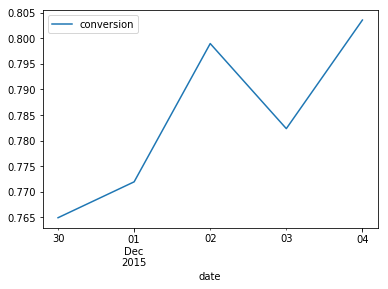

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ratio.set_index('date').plot()

Text(0.5,1,'Test conversion rate')

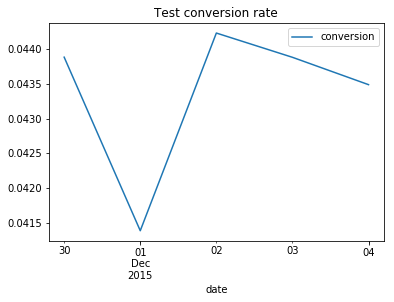

In [ ]:
test_con = df[df.test == 1].groupby('date').conversion.mean().reset_index( )
test_con.set_index('date').plot()
plt.title("Test conversion rate")

Text(0.5,1,'Control conversion rate')

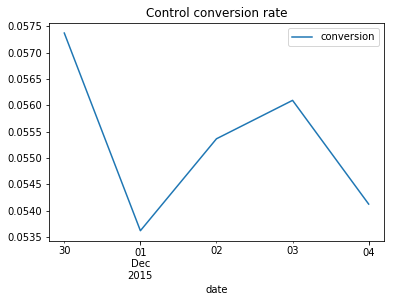

In [ ]:
control_con = df[df.test == 0].groupby('date').conversion.mean().reset_index( )
control_con.set_index('date').plot()
plt.title("Control conversion rate")

### 4. Test with countries controlled 

In [ ]:
countries = [name for name in df['country'].unique() if name is not np.nan]

countries.remove('Spain')

In [ ]:
from scipy.stats import ttest_ind

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = df[(df['country'] == country) & (df['test'] == 1)]['conversion'].values
    cont_val = df[(df['country'] == country) & (df['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849  